# Predictive model implementation

This notebook contains model preprocessing, training and evaluation.

In [1]:
import os
import sys

# Set-up notebook environment to include thoth_issue_predictor module.
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path

'/home/tjanicek/thesis/thoth-issue-predictor'

In [2]:
from IPython.core.display import display
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import Pool, CatBoostClassifier
from datetime import datetime
from thoth_issue_predictor.preprocessing.grid_search import (
    grid_search_catboost,
    grid_search_scikit,
)
from thoth_issue_predictor.evaluation.metrics import Metrics
from thoth_issue_predictor.evaluation.model_evaluation import ModelEvaluation
from thoth_issue_predictor.preprocessing.preprocessing import Preprocessing

## Model Preprocessing

Model preprocessing is done in three stages:
 - function `prepare_df` unpacks data from archive file and creates dataframe with raw data.
 - class `Preprocessing` extracts relevant data
 - cell below drops duplicates
 - cell below splits dataset into test and train datasets

In [3]:
preprocessing = Preprocessing()
inspections_df = preprocessing.prepare_df()
issues_df, python_indexes = preprocessing.create_df()

In [4]:
# Drops duplicates and sets columns exit_code to correct representations.
issues_df["exit_code"] = inspections_df["exit_code"].astype("int")
issues_df = issues_df.loc[
    (issues_df.loc[:, issues_df.columns != "exit_code"] != 0).any(axis=1)
]
issues_df = issues_df.drop_duplicates()

In [5]:
python_indexes

['unknown', 'pypi-org-simple', 'pypi-org', 'aicoe', 'pypi']

In [6]:
issue_x, exit_codes = issues_df.drop("exit_code", axis=1), issues_df["exit_code"]

X_train, X_test, y_train, y_test = train_test_split(
    issue_x, exit_codes, test_size=0.4, random_state=0
)

In [7]:
display(f"Length of DF is {len(issues_df)}")
issues_df.head(5)

'Length of DF is 1947'

,python,tensorflow_major,tensorflow_minor,tensorflow_micro,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_micro,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_micro,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_micro,tensorflow-cpu_index,exit_code
0,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,38,2,4,0,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## Failed inspections

This section filters and visualizes failed software stacks from whole dataframe.

In [8]:
failed_inspections = issues_df[issues_df["exit_code"] == 1]
display(f"Number of failed inspections: {len(failed_inspections)}")
failed_inspections.head()

'Number of failed inspections: 102'

,python,tensorflow_major,tensorflow_minor,tensorflow_micro,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_micro,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_micro,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_micro,tensorflow-cpu_index,exit_code
1896,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1897,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1898,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1899,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1900,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Scikit CART model

This section contains implementation of Scikit DT model.
The implementation is done in stages:
 - get the best parameters using grid search
 - train classifier using train subset
 - create tree visualization and export it to `thoth_issue_predictor/visualizations/ThothIssuePredictor.pdf`
 - visualize the performance of model and save metric for comparisons

In [9]:
best_params = grid_search_scikit(X_train, y_train)
best_params

{'max_depth': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'splitter': 'random'}

In [10]:
clf = DecisionTreeClassifier(**best_params)

start = datetime.now()
clf.fit(X_train, y_train)
end = datetime.now()

In [11]:
feature_names = issue_x.columns
target_names = ["successful", "failed"]
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_names,
    class_names=target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("visualizations/ThothIssuePredictor", format="pdf")

'visualizations/ThothIssuePredictor.pdf'

Train time: 0:00:00.005593
Prediction time: 0:00:00.003933
Number of errors: 14
AUC: 0.8933818433818432
Accuracy: 0.982028241335045
Precision: 0.8378378378378378
Recall: 0.7948717948717948
F1: 0.8157894736842105
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       740
           1       0.84      0.79      0.82        39

    accuracy                           0.98       779
   macro avg       0.91      0.89      0.90       779
weighted avg       0.98      0.98      0.98       779

Confusion matrix for scikit
[[734   6]
 [  8  31]]


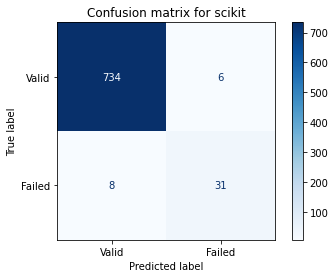

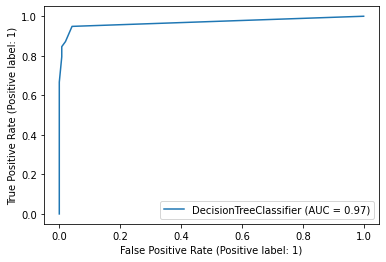

In [12]:
scikit_evaluation = ModelEvaluation("scikit", clf, end - start, X_test, y_test)
scikit_evaluation.predict_and_save()
scikit_evaluation.print()

## CatBoost GBDT model

This section contains implementation of CatBoost model.
The implementation is done in stages:
 - get the best parameters using grid search
 - train classifier using train subset
 - create tree visualization and export it to `thoth_issue_predictor/visualizations/ThothIssuePredictorBoost.pdf`
 - visualize the performance of model and save metric for comparisons

In [13]:
cat_features = [f for f in feature_names if "_index" in f]

issue_pool = Pool(issue_x, exit_codes, cat_features=cat_features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [14]:
best_params = grid_search_catboost(train_pool)


bestTest = 0.9950396825
bestIteration = 24

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9950396825
bestIteration = 24

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.998015873
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.998015873
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate t

In [15]:
clf = CatBoostClassifier(use_best_model=True, **best_params)
best_params

{'min_data_in_leaf': 3,
 'depth': 4,
 'iterations': 1000,
 'grow_policy': 'Depthwise',
 'verbose': False,
 'eval_metric': 'AUC',
 'loss_function': 'Logloss'}

In [16]:
start = datetime.now()
clf.fit(train_pool, eval_set=train_pool)
end = datetime.now()

In [17]:
dot_data = clf.plot_tree(0, pool=test_pool)
graph = graphviz.Source(dot_data)
graph.render("visualizations/ThothIssuePredictorBoost", format="pdf")

'visualizations/ThothIssuePredictorBoost.pdf'

Train time: 0:00:02.892841
Prediction time: 0:00:00.002061
Number of errors: 6
AUC: 0.9230769230769231
Accuracy: 0.9922978177150192
Precision: 1.0
Recall: 0.8461538461538461
F1: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       740
           1       1.00      0.85      0.92        39

    accuracy                           0.99       779
   macro avg       1.00      0.92      0.96       779
weighted avg       0.99      0.99      0.99       779

Confusion matrix for catboost
[[740   0]
 [  6  33]]


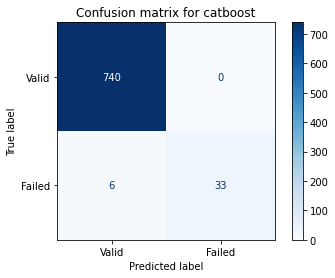

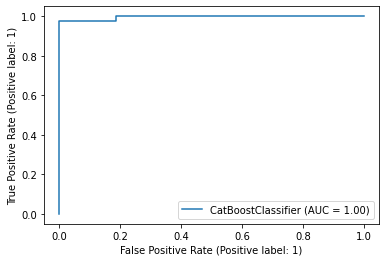

In [18]:
catboost_evaluation = ModelEvaluation("catboost", clf, end - start, test_pool, y_test)
catboost_evaluation.predict_and_save()
catboost_evaluation.print()

## Model Comparison

This section compares used models and visualizes the results.

'--------------------------------------------'

'Results for each category from best to worst'

'--------------------------------------------'

train_time:
1. scikit: 0:00:00.005593
2. catboost: 0:00:02.892841


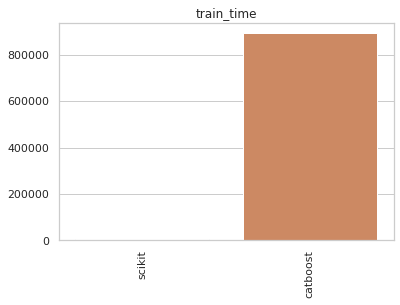

prediction_time:
1. catboost: 0:00:00.002061
2. scikit: 0:00:00.003933


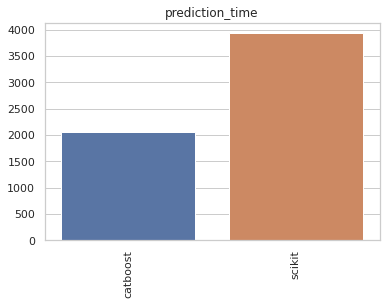

number_of_errors:
1. catboost: 6
2. scikit: 14


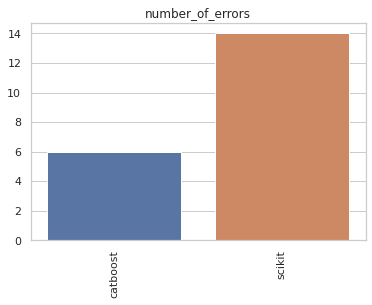

auc:
1. catboost: 0.9230769230769231
2. scikit: 0.8933818433818432


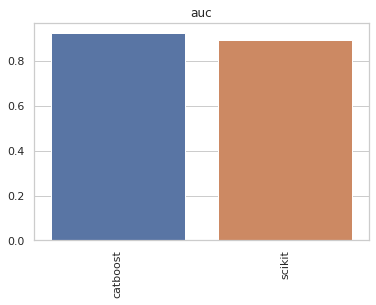

accuracy:
1. catboost: 0.9922978177150192
2. scikit: 0.982028241335045


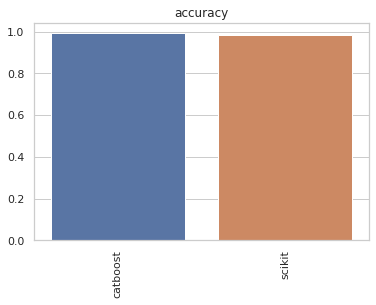

precision:
1. catboost: 1.0
2. scikit: 0.8378378378378378


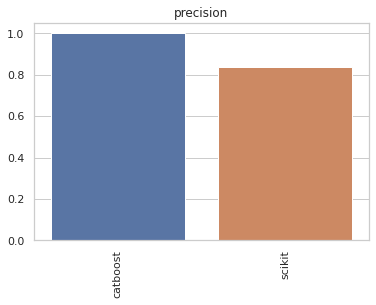

recall:
1. catboost: 1.0
2. scikit: 0.8378378378378378


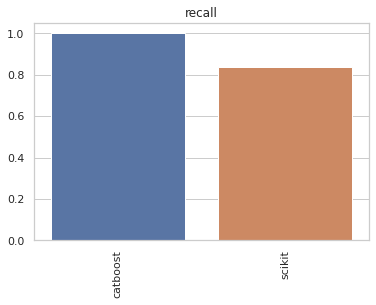

f1:
1. catboost: 0.9166666666666666
2. scikit: 0.8157894736842105


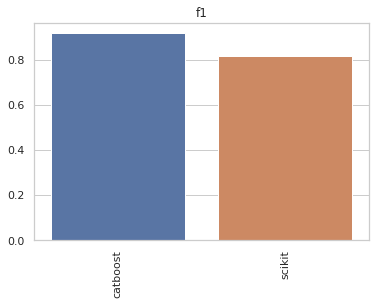

'-----------------------------'

'Best models for each category'

'-----------------------------'

train_time: scikit
prediction_time: catboost
number_of_errors: catboost
auc: catboost
accuracy: catboost
precision: catboost
recall: catboost
f1: catboost


In [19]:
metrics = Metrics([scikit_evaluation, catboost_evaluation])

metrics.sort_metrics()
display("--------------------------------------------")
display("Results for each category from best to worst")
display("--------------------------------------------")
metrics.print_results()

display("-----------------------------")
display("Best models for each category")
display("-----------------------------")
metrics.print_best()

### Analysis of visualized trees

Cell below filters dataset using conditions from Scikit DT visualization.
Main reason to doing so is trying to find the reason why certain software
stacks failed. Displayed dataframe show that all f
ailed software stack
share the same version of package Utllib3.

This [link](https://thoth-station.ninja/j/tf_21_urllib3.html) is a documentation of this issue
occurring during other resolutions.

In [20]:
urllib_cols = ["urllib3_major", "urllib3_minor", "urllib3_micro"]
chardet_minor_filter = issues_df["chardet_minor"] > 1.555
urllib_df = issues_df[chardet_minor_filter]
urllib_minor_filter = urllib_df["urllib3_minor"] <= 11.209
urllib_df = urllib_df[urllib_minor_filter]
urllib_micro_filter = urllib_df["urllib3_minor"] <= 8.654
urllib_df = urllib_df[urllib_micro_filter][urllib_cols]
urllib_df.drop_duplicates()

,urllib3_major,urllib3_minor,urllib3_micro
1896,1,5,0
